## Obiettivo progetto
* Partendo da un dataset di un servizio di car sharing, con i campionamenti delle posizioni delle auto parcheggiate in città, si tenta di predire quanto tempo rimarrà un'auto se parcheggiata in un certo momento e in un certo luogo

### Dataset utilizzati
* dataset di partenza: https://www.kaggle.com/doit-intl/autotel-shared-car-locations
  * estratti record da tabella `sample_view` su https://bigquery.cloud.google.com/dataset/gad-playground-212407:doit_intl_autotel_public perchè sono su un range temporale maggiore della tabella su kaggle
* dati su posizioni quartieri e feature pre-aggregate da tabella `neighborhood_features` https://bigquery.cloud.google.com/dataset/gad-playground-212407:doit_intl_autotel_public 
* dati temperature da http://www.iacdc.tau.ac.il/data-access/datasets/ims/ims-data/
* calendario festività isrealiane estratto da https://www.officeholidays.com/countries/israel/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from shapely.geometry import Point, Polygon
from shapely import wkt
from IPython.display import clear_output
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.base import clone
from sklearn.svm import SVR, SVC

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

sns.set(rc={'figure.figsize':(16, 5)})

In [2]:
df = pd.read_csv('dataset/sample_view.csv', parse_dates=['timestamp'])

df.head()

timestamp   latitude  longitude  total_cars  \
0 2018-10-16 06:40:42.636000+00:00  32.084900  34.796600           5   
1 2018-10-16 07:50:05.227000+00:00  32.084900  34.796600           6   
2 2018-10-10 12:44:11.880000+00:00  32.111506  34.840876           5   
3 2018-12-03 08:34:00.219000+00:00  32.084900  34.796600           4   
4 2018-12-03 09:44:51.615000+00:00  32.109740  34.812380           6   

                       carsList  
0        [36, 81, 93, 137, 139]  
1    [32, 36, 81, 93, 137, 139]  
2       [6, 171, 218, 243, 269]  
3          [116, 135, 237, 251]  
4  [39, 90, 192, 198, 203, 210]

### Verifica della completezza dei dati

In [3]:
df.isnull().sum()

timestamp     0
latitude      0
longitude     0
total_cars    0
carsList      0
dtype: int64

### Controllo e correzione tipi
* trasformazione di 'carsList' a lista di id delle auto

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5146601 entries, 0 to 5146600
Data columns (total 5 columns):
timestamp     datetime64[ns, UTC]
latitude      float64
longitude     float64
total_cars    int64
carsList      object
dtypes: datetime64[ns, UTC](1), float64(2), int64(1), object(1)
memory usage: 196.3+ MB


In [5]:
df['carsList'] = df['carsList'].apply(lambda carsList: set(literal_eval(carsList)))

### Numero totale di posizioni di parcheggi registrate
* sono troppe, sarà necessario raggrupparle

In [6]:
df.groupby(['latitude', 'longitude']).size()

latitude  longitude
32.03017  34.74850       1
          34.74851      53
32.03018  34.74855     117
32.03022  34.74845     428
          34.74846       1
                      ... 
32.14627  34.79248     641
32.14629  34.79249     137
32.14631  34.79248       1
          34.79249      85
32.17015  35.03582       1
Length: 44389, dtype: int64

### Numero totale di auto

In [7]:
carIds = set()

for carIdsList in df['carsList']:
    for carId in carIdsList:
        carIds.add(carId)

print('total number of cars: {}'.format(len(carIds)))

total number of cars: 260


## Estrazione nuovo dataframe
* per ottenere le informazioni su tempo, luogo e durata della permanenza delle auto parcheggiate
* formato desiderato: <position, timestamp, parking_duration>

In [8]:
EXTRACTED_COLUMNS = ['timestamp', 'latitude', 'longitude', 'duration']

def new_record(row, arrival_timestamp):
    seconds_delta = (row['timestamp'] - arrival_timestamp).seconds
    return [arrival_timestamp, row['latitude'], row['longitude'], seconds_delta]

def extract_parking_duration_rows(limit = 1E10):
    result = []

    rows_processed = 0
    for (lat, lon), group in df.groupby(['latitude', 'longitude']):
        group = group.sort_values(by=['timestamp'])
        cars_arrival_times = {}

        last_row_processed = None
        for _, record in group.iterrows():
            last_row_processed = record
            
            car_ids_to_delete = []
            for car_id, arrival_time in cars_arrival_times.items():
                if car_id not in record['carsList']:
                    result.append(new_record(record, arrival_time))
                    car_ids_to_delete.append(car_id)
            
            for car_id in car_ids_to_delete:
                del cars_arrival_times[car_id]
                
            for car_id in record['carsList']:
                if car_id not in cars_arrival_times.keys():
                    cars_arrival_times[car_id] = record['timestamp']

            rows_processed += 1
            if rows_processed % 1000 == 0:
                clear_output(wait=True)
                rows_limit = min(limit, len(df.index))
                print('rows processed: {}/{}'.format(rows_processed, rows_limit))

        if rows_processed >= limit:
            clear_output(wait=True)
            print('DONE. rows processed: {}'.format(rows_processed))
            break
    
    return result

#### Estrazione effettiva
* impiega da 5 a 10 minuti
* usare ```cached=True``` in ```get_parking_duration_df()``` per velocizzare

In [9]:
def get_parking_duration_df(cached=True):
    if(cached):
        return pd.read_csv('./dataset/partials/parking_duration_rows.csv', parse_dates=['timestamp'])

    rows = extract_parking_duration_rows()
    return pd.DataFrame(rows, columns=EXTRACTED_COLUMNS)

parking_duration_df = get_parking_duration_df(cached=True)

parking_duration_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23743 entries, 0 to 23742
Data columns (total 4 columns):
timestamp    23743 non-null datetime64[ns, UTC]
latitude     23743 non-null float64
longitude    23743 non-null float64
duration     23743 non-null int64
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 742.1 KB


### Normalizzazione durata
* da secondi a minuti e ore

In [10]:
parking_duration_df['duration_minutes'] = (parking_duration_df['duration'] / 60).round().astype('int64')
parking_duration_df['duration_hours'] = (parking_duration_df['duration_minutes'] / 60).round().astype('int64')

parking_duration_df.drop(columns=['duration'], inplace=True)

### Valori dei tempi di permanenza

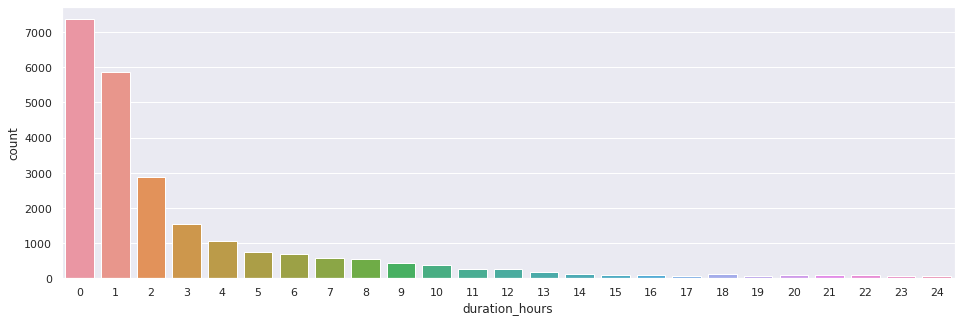

In [11]:
sns.set(rc={'figure.figsize':(16, 5)})
sns.countplot(data=parking_duration_df, x='duration_hours')

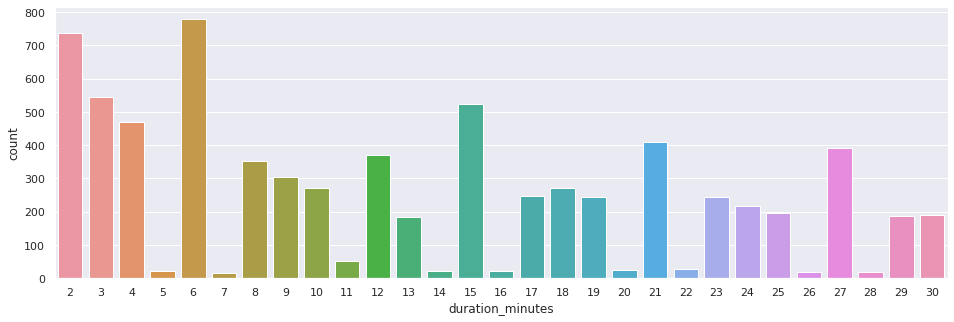

In [12]:
short_term_parking_df = parking_duration_df[parking_duration_df['duration_hours'] < 1]
sns.countplot(data=short_term_parking_df, x='duration_minutes')

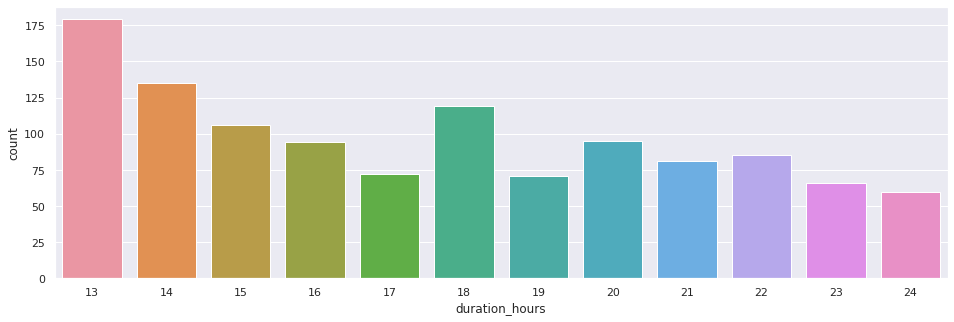

In [13]:
long_term_parking_df = parking_duration_df[parking_duration_df['duration_hours'] > 12]
sns.countplot(data=long_term_parking_df, x='duration_hours')

### Aggiunta feature "quartiere"
* mapping delle coordinate ai quartieri
* aggiunta feature pre-aggregate sui quartieri

In [14]:
df_neighborhoods = pd.read_csv('dataset/tel_aviv_neighborhood_features_complete.csv')
df_neighborhoods.head()

neighborhood_name  neighborhood_id  age5to14  age15to19  age20to29  \
0         Sde Dov area                3      12.4        5.0       10.6   
1        Spring Cliffs                2      14.0        4.6        9.6   
2         Ramat Aviv c                7      14.6        5.1        9.7   
3  Tel aviv university               11      11.4        5.1       17.4   
4           North Star                6      10.6        4.6       17.2   

   age30to34  age35to49  age50to64  total_kingrtn  total_hotels  \
0        6.2       20.6       16.0            NaN           NaN   
1        6.8       21.4       15.3            4.0           NaN   
2        6.5       21.4       15.3           11.0           NaN   
3        7.2       19.0       13.1            1.0           NaN   
4        7.6       19.3       13.6            1.0           NaN   

                                        area_polygon  
0  POLYGON ((34.788389 32.123656, 34.788383 32.12...  
1  POLYGON ((34.796243 32.130388, 34.795859 32.12...  
2  POLYGON ((34.808554 32.128712, 34.808641 32.12...  
3  POLYGON ((34.802354 32.118062, 34.80239 32.118...  
4  POLYGON ((34.783522 32.098636, 34.783493 32.09...

### Correzione dati mancanti
* si assume che il valore null per il numero di asili e hotel rappresenti mancanza degli stessi

In [15]:
df_neighborhoods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 11 columns):
neighborhood_name    71 non-null object
neighborhood_id      71 non-null int64
age5to14             71 non-null float64
age15to19            71 non-null float64
age20to29            71 non-null float64
age30to34            71 non-null float64
age35to49            71 non-null float64
age50to64            71 non-null float64
total_kingrtn        62 non-null float64
total_hotels         12 non-null float64
area_polygon         71 non-null object
dtypes: float64(8), int64(1), object(2)
memory usage: 6.2+ KB


In [16]:
df_neighborhoods['total_kingrtn'].fillna(0, inplace=True)
df_neighborhoods['total_hotels'].fillna(0, inplace=True)

In [17]:
neighborhoods = df_neighborhoods[['neighborhood_id', 'area_polygon']].values

def load_and_close_polygon(wkt_text):
    poly = wkt.loads(wkt_text)
    point_list = poly.exterior.coords[:]
    point_list.append(point_list[0])
    return Polygon(point_list)

neighborhoods = [(n_id, load_and_close_polygon(poly_string)) for (n_id, poly_string) in neighborhoods]

def get_neighborhood(row):
    point = Point(row['longitude'], row['latitude'])
    for (n_id, polygon) in neighborhoods:
        if point.within(polygon):
            return n_id

In [18]:
parking_duration_df['neighborhood_id'] = parking_duration_df.apply(get_neighborhood, axis=1)
parking_duration_df.drop(columns=['latitude', 'longitude'], inplace=True)

### Verifica della correttezza del mapping

In [19]:
parking_duration_df['neighborhood_id'].isnull().sum()

0

### Aggiunta features pre-aggregate quartieri
* fasce d'età presenti, numero di hotel e numero di asili

In [20]:
columns_to_add = ['age5to14','age15to19','age20to29', 'age30to34', 'age35to49' ,'age50to64']
columns_to_add += ['total_kingrtn', 'total_hotels']

parking_duration_df = pd.merge(parking_duration_df, df_neighborhoods[columns_to_add + ['neighborhood_id']], on='neighborhood_id')

### Aggiunta features estratte dal timestamp
* attributi "ora", "weekend" e "holiday"

In [21]:
parking_duration_df['hour'] = parking_duration_df['timestamp'].dt.hour

In [22]:
il_non_working_days = [4,5] # wednesday and saturday

parking_duration_df['weekend'] = parking_duration_df['timestamp'].dt.weekday.isin(il_non_working_days).astype('int64')

In [23]:
dateparse = lambda x: pd.datetime.strptime(x, '%d-%m-%Y')

il_holidays_df = pd.read_csv('./dataset/israel_holidays.csv', parse_dates=['date'], date_parser=dateparse)
il_holidays = pd.DatetimeIndex(il_holidays_df['date'])

def get_is_holiday(timestamp):
    return 1 if timestamp.date() in il_holidays else 0

parking_duration_df['holiday'] = parking_duration_df['timestamp'].apply(get_is_holiday)

In [24]:
parking_duration_df.head()

timestamp  duration_minutes  duration_hours  \
0 2018-10-11 15:05:35.412000+00:00              1329              22   
1 2019-09-19 20:33:02.923000+00:00               243               4   
2 2018-11-26 15:42:47.716000+00:00               205               3   
3 2018-12-01 18:10:37.320000+00:00                15               0   
4 2019-09-13 00:00:33.697000+00:00              1343              22   

   neighborhood_id  age5to14  age15to19  age20to29  age30to34  age35to49  \
0               47      14.2        6.8       14.4        8.1       18.5   
1               47      14.2        6.8       14.4        8.1       18.5   
2               47      14.2        6.8       14.4        8.1       18.5   
3               47      14.2        6.8       14.4        8.1       18.5   
4               49      13.3        6.2       14.5        8.0       18.4   

   age50to64  total_kingrtn  total_hotels  hour  weekend  holiday  
0       15.9            7.0           0.0    15        0        0  
1       15.9            7.0           0.0    20        0        0  
2       15.9            7.0           0.0    15        0        0  
3       15.9            7.0           0.0    18        1        0  
4       16.6           10.0           0.0     0        1        0

### Aggiunta feature ulteriori sull'orario

In [25]:
minutes_in_a_day = 24 * 60
time_in_seconds = pd.to_datetime(parking_duration_df['timestamp']).values.astype(np.int64)
parking_duration_df['time_in_minutes'] = time_in_seconds / 60

sin_time_minutes = np.sin(2 * np.pi * parking_duration_df['time_in_minutes'] / minutes_in_a_day)
cos_time_minutes = np.cos(2 * np.pi * parking_duration_df['time_in_minutes'] / minutes_in_a_day)

sin_time_hour = np.sin(2 * np.pi * parking_duration_df['timestamp'].dt.hour / 24)
cos_time_hour = np.cos(2 * np.pi * parking_duration_df['timestamp'].dt.hour / 24)

parking_duration_df['sin_time_hours'] = sin_time_hour
parking_duration_df['cos_time_hours'] = cos_time_hour
parking_duration_df['sin_time_minutes'] = sin_time_minutes
parking_duration_df['cos_time_minutes'] = cos_time_minutes

# Verifica delle correlazioni
* nessun attributo con una correlazione rilevante agli attributi di durata (duration_hours e duration_minutes)
  * neanche il quartiere

In [26]:
corr = parking_duration_df.corr()
corr.style.background_gradient(cmap='coolwarm')

# Tentativi di predizione con regressione
* risultati molto scarsi con diverse

In [27]:
# viene eseguito one hot encoding delle colonne indicate nel terzo attributo
def get_clf_data(data, columns, columns_to_encode):
    result = []
    
    for column in columns:
        result += [data[column] if column not in columns_to_encode else pd.get_dummies(data[column], prefix=column)]
    
    return pd.concat(result, axis=1)

In [28]:
def test_regression_models(data, target, models):
    res = []
    
    for (name, model) in models:      
        clear_output(wait=True)
        print('testing: {}'.format(name))
        
        model_full_data = clone(model)
        model_full_data.fit(data, target)
        full_data_score = model_full_data.score(data, target)
        
        full_data_mse = mean_squared_error(target, model_full_data.predict(data))
        
        Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, test_size=0.25, random_state=42)  
        model_split_data = clone(model)
        model_split_data.fit(Xtrain, ytrain)
        split_data_score = model_split_data.score(Xtest, ytest)
        
        split_data_mse = mean_squared_error(ytest, model_split_data.predict(Xtest))
        
        new_record = {'name': name,
                      'full_data_score': full_data_score, 'split_data_score': split_data_score,
                      'full_data_mse': full_data_mse, 'split_data_mse': split_data_mse}
        
        res.append(new_record)
        
    clear_output()
    return pd.DataFrame(res)

## Note
* viene eseguito il one hot encoding dell'attributo neighborhood_id (dal metodo get_clf_data)
* l'uso di PolynomialFeatures aumenta le precisioni solo di 0.01
  * probabilmente per il one hot encoding di "neighborhood_id", i quartieri sono 71
  * non l'ho incluso perchè allunga l'esecuzione a molti minuti e non ha aiutato
* le combinazioni di parametri mostrate sono d'esempio (ne sono state provate molte altre senza successo)
* non avendo trovato punteggi accettabili nemmeno addestrando e testando sugli stessi dati, non sembrano esserci correlazioni utili alla predizione tra i dati (perciò non ho tentato tuning dei parametri)

## Tentativo di predizione durata in minuti

In [29]:
models = [
    ('LinearRegression', LinearRegression(fit_intercept=False)), 
    ('Lasso', Lasso(fit_intercept=False)), 
    ('Ridge', Ridge(fit_intercept=False)), 
    ('ElasticNet', ElasticNet(fit_intercept=False)), 
    ('DecisionTreeRegressor', DecisionTreeRegressor()), 
    ('GradientBoostingRegressor', GradientBoostingRegressor())
]

columns_to_encode = ['neighborhood_id', 'hour', 'holiday', 'weekend']

def test_base_regressors(columns, target_column):
    final_data = get_clf_data(parking_duration_df, columns, columns_to_encode)
    target = parking_duration_df[target_column]

    return test_regression_models(final_data, target, models)

In [30]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.168496          0.165738   
1                      Lasso         0.004966         -0.009861   
2                      Ridge         0.168270          0.164936   
3                 ElasticNet        -0.406697         -0.409597   
4      DecisionTreeRegressor         0.279772          0.093792   
5  GradientBoostingRegressor         0.176431          0.158356   

   full_data_mse  split_data_mse  
0   56832.525811    58641.984248  
1   68009.672870    70985.236854  
2   56847.966220    58698.396499  
3   96146.479247    99083.455184  
4   49226.899255    63699.199047  
5   56290.201654    59160.894758

In [31]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.169083          0.164895   
1                      Lasso         0.114684          0.114118   
2                      Ridge         0.169056          0.165031   
3                 ElasticNet        -0.014923         -0.019203   
4      DecisionTreeRegressor         0.377266          0.023652   
5  GradientBoostingRegressor         0.178660          0.157474   

   full_data_mse  split_data_mse  
0   56792.386641    58701.266047  
1   60510.534107    62270.454623  
2   56794.272790    58691.720276  
3   69369.070412    71641.874020  
4   42563.322737    68629.505613  
5   56137.811203    59222.865269

In [32]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'age5to14', 'age15to19', 'age20to29', 'age30to34', 'age35to49', 'age50to64'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.168496          0.165738   
1                      Lasso         0.140811          0.145001   
2                      Ridge         0.168473          0.166090   
3                 ElasticNet         0.114769          0.117985   
4      DecisionTreeRegressor         0.279772          0.091936   
5  GradientBoostingRegressor         0.192505          0.178023   

   full_data_mse  split_data_mse  
0   56832.535264    58641.984248  
1   58724.784160    60099.661449  
2   56834.137523    58617.282043  
3   60504.719881    61998.642457  
4   49226.899255    63829.717612  
5   55191.562326    57778.475187

## Tentativo di predizione durata in ore

In [33]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours'], 'duration_hours')

name  full_data_score  split_data_score  \
0           LinearRegression         0.168265          0.165667   
1                      Lasso        -0.458912         -0.461196   
2                      Ridge         0.168043          0.164834   
3                 ElasticNet        -0.455965         -0.458413   
4      DecisionTreeRegressor         0.278785          0.090910   
5  GradientBoostingRegressor         0.175570          0.157916   

   full_data_mse  split_data_mse  
0      16.058439       16.584672  
1      28.167460       29.045317  
2      16.062738       16.601225  
3      28.110563       28.989995  
4      13.924612       18.070686  
5      15.917414       16.738744

In [34]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.169083          0.164895   
1                      Lasso         0.114684          0.114118   
2                      Ridge         0.169056          0.165031   
3                 ElasticNet        -0.014923         -0.019203   
4      DecisionTreeRegressor         0.377266          0.016505   
5  GradientBoostingRegressor         0.178660          0.157496   

   full_data_mse  split_data_mse  
0   56792.386641    58701.266047  
1   60510.534107    62270.454623  
2   56794.272790    58691.720276  
3   69369.070412    71641.874020  
4   42563.322737    69131.917852  
5   56137.811203    59221.370556

# Tentativo di predizione con classificatore
* si tenta di predire il tempo di sosta espresso in fascia oraria
* risultati ancora scarsi

In [35]:
def normalize_time(minutes):
    # max 24 ore
    ranges = [[7.5, 5], [15, 10], [25, 20], [40, 30], [80, 60], [160, 120], [300, 240], [390, 360]]

    for range_limit, value in ranges:
        if minutes < range_limit:
            return value
    
    # 360 represents "6 hours or more" label
    return 360

parking_duration_df['parking_duration_normalized'] = parking_duration_df['duration_minutes'].apply(normalize_time)

### Verifica bilanciamento classi

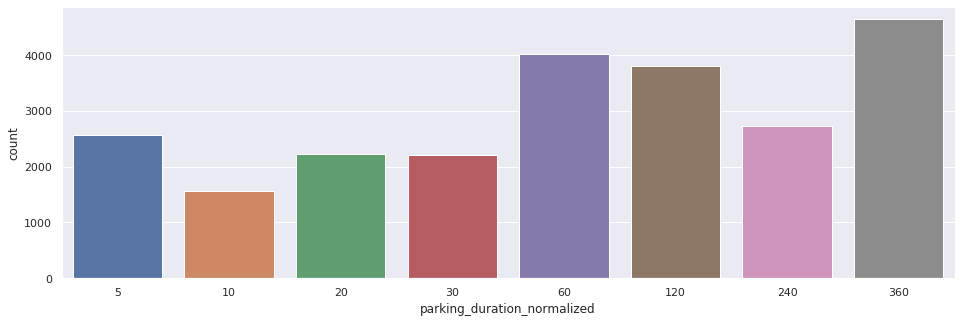

In [36]:
sns.countplot(data=parking_duration_df, x='parking_duration_normalized')

In [37]:
def test_clf_models(data, target, models):
    res = []
    
    for (name, model) in models:      
        clear_output(wait=True)
        print('testing: {}'.format(name))
        
        Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, test_size=0.25, random_state=42)  
        model = clone(model)
        model.fit(Xtrain, ytrain)
        score = model.score(Xtest, ytest)
        
        new_record = {'name': name, 'score': score}
        
        res.append(new_record)
        
    clear_output()
    return pd.DataFrame(res)

In [38]:
classifiers = [
    ('KNeighborsClassifier', KNeighborsClassifier()),
    ('DecisionTreeClassifier', DecisionTreeClassifier()),
    ('RandomForestClassifier', RandomForestClassifier())
]

def test_base_classifiers(columns, target_column, data=parking_duration_df):
    final_data = get_clf_data(data, columns, columns_to_encode)
    target = data[target_column]

    return test_clf_models(final_data, target, classifiers)

In [39]:
test_base_classifiers(['neighborhood_id', 'cos_time_hours', 'sin_time_hours'], 'parking_duration_normalized')

name     score
0    KNeighborsClassifier  0.210243
1  DecisionTreeClassifier  0.250000
2  RandomForestClassifier  0.259265

In [40]:
test_base_classifiers(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday'], 'parking_duration_normalized')

name     score
0    KNeighborsClassifier  0.221193
1  DecisionTreeClassifier  0.247810
2  RandomForestClassifier  0.256739

# Aggiunta feature temperatura
* (i dati sulle precipitazioni non sono stati trovati)
* viene associata ai record la temperatura da un dataset con campionamento orario
* per via della ridotta estensione temporale dei dati, rimuoviamo parte del dataset e ritrattiamo questa sezione a parte

In [41]:
weather_df = pd.read_csv('dataset/weather/tel_aviv.csv', parse_dates=['time'])
weather_df['time'] = pd.to_datetime(weather_df['time'], utc=True)

In [42]:
print("weather df max timestamp: {}".format(weather_df['time'].max()))
print("parking duration df max timestamp: {}".format(parking_duration_df['timestamp'].max()))

records_to_discard = parking_duration_df[parking_duration_df['timestamp'] > '2019-06-30 21:00:00']
print('records to discard: {}'.format(len(records_to_discard)))
print('total records: {}'.format(len(parking_duration_df)))

weather df max timestamp: 2019-06-30 21:00:00+00:00
parking duration df max timestamp: 2019-09-22 10:54:02.485000+00:00
records to discard: 9478
total records: 23743


In [43]:
parking_duration_df = parking_duration_df[parking_duration_df['timestamp'] < '2019-06-30 21:00:00']

## Verifica della correttezza del dataset
* deve esistere un solo record per timestamp

In [44]:
print('records number: {}'.format(len(weather_df['time'])))
print('timestamps nunique: {}'.format(weather_df['time'].nunique()))

records number: 4367
timestamps nunique: 4367


## Mapping feature temperatura (tas) ai record

In [45]:
weather_df.rename(columns={'time': 'tmp_time'}, inplace=True, errors='raise')
parking_duration_df['tmp_time'] = parking_duration_df['timestamp'].apply(lambda ts: ts.floor(freq='h'))

/home/luca/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
parking_duration_df = pd.merge(parking_duration_df, weather_df[['tmp_time', 'tas']], on='tmp_time')
parking_duration_df.drop(columns=['tmp_time'], inplace=True)

### Verifica della completezza del mapping

In [47]:
parking_duration_df['tas'].isnull().sum()

0

# Test con uso della feature temperatura
* anche in questo caso, le combinazioni di parametri rappresentate sono d'esempio, ne sono state provate molte di più
* i risultati dei test addirittura peggiorano aggiungendo la variabile
  * i mean_squared_error delle predizioni del numero di ore aumentano notevolmente

### Ripetizione dei test con i regressori

In [48]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'tas'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.208312          0.144550   
1                      Lasso         0.129005          0.103947   
2                      Ridge         0.202363          0.135761   
3                 ElasticNet         0.026340          0.024691   
4      DecisionTreeRegressor         0.639609         -0.225647   
5  GradientBoostingRegressor         0.253151          0.130376   

   full_data_mse  split_data_mse  
0   58133.596514    67964.363169  
1   63957.098532    71190.208459  
2   58570.474030    68662.624089  
3   71495.787932    77486.940074  
4   26463.497928    97375.966033  
5   54841.052967    69090.435202

In [49]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday', 'tas'], 'duration_minutes')

name  full_data_score  split_data_score  \
0           LinearRegression         0.210142          0.144511   
1                      Lasso         0.139906          0.114684   
2                      Ridge         0.209152          0.144324   
3                 ElasticNet         0.027441          0.025768   
4      DecisionTreeRegressor         0.670388         -0.257429   
5  GradientBoostingRegressor         0.257878          0.134495   

   full_data_mse  split_data_mse  
0   57999.199509    67967.426337  
1   63156.676397    70337.135877  
2   58071.959443    67982.305966  
3   71414.980823    77401.441890  
4   24203.386407    99901.047857  
5   54493.965902    68763.200482

In [50]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'tas'], 'duration_hours')

name  full_data_score  split_data_score  \
0           LinearRegression         0.207104          0.144829   
1                      Lasso        -0.022476         -0.023749   
2                      Ridge         0.201284          0.136111   
3                 ElasticNet        -0.014736         -0.016498   
4      DecisionTreeRegressor         0.638380         -0.204143   
5  GradientBoostingRegressor         0.253135          0.131788   

   full_data_mse  split_data_mse  
0      16.411568       19.225068  
1      21.163484       23.014874  
2      16.532041       19.421068  
3      21.003284       22.851858  
4       7.484896       27.070311  
5      15.458810       19.518244

In [51]:
test_base_regressors(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday', 'tas'], 'duration_hours')

name  full_data_score  split_data_score  \
0           LinearRegression         0.208903          0.145120   
1                      Lasso        -0.022476         -0.023749   
2                      Ridge         0.207943          0.144803   
3                 ElasticNet        -0.014736         -0.016498   
4      DecisionTreeRegressor         0.669362         -0.241349   
5  GradientBoostingRegressor         0.258532          0.135971   

   full_data_mse  split_data_mse  
0      16.374327       19.218540  
1      21.163484       23.014874  
2      16.394210       19.225654  
3      21.003283       22.851857  
4       6.843638       27.906736  
5      15.347092       19.424207

### Ripetizione dei test con i classificatori

In [52]:
test_base_classifiers(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'tas'], 'parking_duration_normalized', data=parking_duration_df)

name     score
0    KNeighborsClassifier  0.201164
1  DecisionTreeClassifier  0.201164
2  RandomForestClassifier  0.216126

In [53]:
test_base_classifiers(['neighborhood_id', 'cos_time_hours', 'sin_time_hours', 'weekend', 'holiday', 'tas'], 'parking_duration_normalized', data=parking_duration_df)

name     score
0    KNeighborsClassifier  0.205320
1  DecisionTreeClassifier  0.206983
2  RandomForestClassifier  0.224439

# Conclusioni
* nei dati a disposizione non sono state trovate correlazioni sufficienti per predire la durata della sosta di un'auto quando lasciata in un quartiere ad una certa ora
* suppongo che ulteriori tentativi si potrebbero fare raggruppando i dati in maniera più "fine" che per quartiere, ma i dati sembrano insufficienti per farlo